## Linear Regression

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from datetime import datetime

pumpkins = pd.read_csv('../data/US-pumpkins.csv')

pumpkins.head()

In [ ]:
pumpkins = pumpkins[pumpkins['Package'].str.contains('bushel', case=True, regex=True)]

columns_to_select = ['Package', 'Variety', 'City Name', 'Low Price', 'High Price', 'Date']
pumpkins = pumpkins.loc[:, columns_to_select]

price = (pumpkins['Low Price'] + pumpkins['High Price']) / 2

month = pd.DatetimeIndex(pumpkins['Date']).month
day_of_year = pd.to_datetime(pumpkins['Date']).apply(lambda dt: (dt-datetime(dt.year,1,1)).days)

new_pumpkins = pd.DataFrame(
    {'Month': month, 
     'DayOfYear' : day_of_year, 
     'Variety': pumpkins['Variety'], 
     'City': pumpkins['City Name'], 
     'Package': pumpkins['Package'], 
     'Low Price': pumpkins['Low Price'],
     'High Price': pumpkins['High Price'], 
     'Price': price})

new_pumpkins.loc[new_pumpkins['Package'].str.contains('1 1/9'), 'Price'] = price/1.1
new_pumpkins.loc[new_pumpkins['Package'].str.contains('1/2'), 'Price'] = price*2

new_pumpkins.head()

In [ ]:
print(new_pumpkins['Month'].corr(new_pumpkins['Price']))
print(new_pumpkins['DayOfYear'].corr(new_pumpkins['Price']))

In [ ]:
ax=None
colors = ['red','blue','green','yellow']
for i,var in enumerate(new_pumpkins['Variety'].unique()):
    df = new_pumpkins[new_pumpkins['Variety']==var]
    ax = df.plot.scatter('DayOfYear','Price',ax=ax,c=colors[i],label=var)

In [ ]:
new_pumpkins.groupby('Variety')['Price'].mean().plot(kind='bar')

In [ ]:
pie_pumpkins.dropna(inplace=True)
pie_pumpkins.info()

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [ ]:
X = pie_pumpkins['DayOfYear'].to_numpy().reshape(-1,1)
y = pie_pumpkins['Price']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

lin_reg = LinearRegression()
lin_reg.fit(X_train,y_train)

pred = lin_reg.predict(X_test)

mse = np.sqrt(mean_squared_error(y_test,pred))
print(f'Mean error: {mse:3.3} ({mse/np.mean(pred)*100:3.3}%)')

score = lin_reg.score(X_train,y_train)
print('Model determination: ', score)

plt.scatter(X_test,y_test)
plt.plot(X_test,pred)



In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

pipeline = make_pipeline(PolynomialFeatures(2), LinearRegression())

pipeline.fit(X_train,y_train)

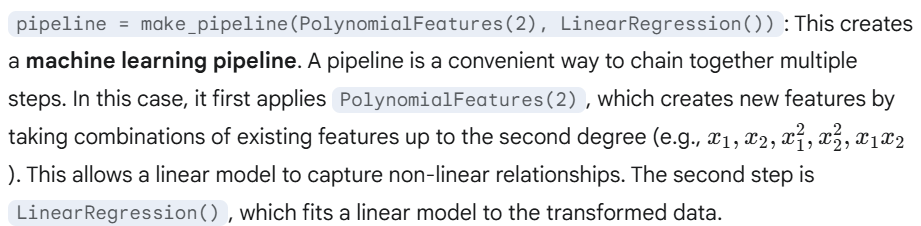

In [ ]:
X = pd.get_dummies(new_pumpkins['Variety'])
y = new_pumpkins['Price']

In [ ]:
X = pd.get_dummies(new_pumpkins['Variety']) \
        .join(new_pumpkins['Month']) \
        .join(pd.get_dummies(new_pumpkins['City'])) \
        .join(pd.get_dummies(new_pumpkins['Package']))
y = new_pumpkins['Price']

In [ ]:
# set up training data
X = pd.get_dummies(new_pumpkins['Variety']) \
        .join(new_pumpkins['Month']) \
        .join(pd.get_dummies(new_pumpkins['City'])) \
        .join(pd.get_dummies(new_pumpkins['Package']))
y = new_pumpkins['Price']

# make train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# setup and train the pipeline
pipeline = make_pipeline(PolynomialFeatures(2), LinearRegression())
pipeline.fit(X_train,y_train)

# predict results for test data
pred = pipeline.predict(X_test)

# calculate MSE and determination
mse = np.sqrt(mean_squared_error(y_test,pred))
print(f'Mean error: {mse:3.3} ({mse/np.mean(pred)*100:3.3}%)')

score = pipeline.score(X_train,y_train)
print('Model determination: ', score)

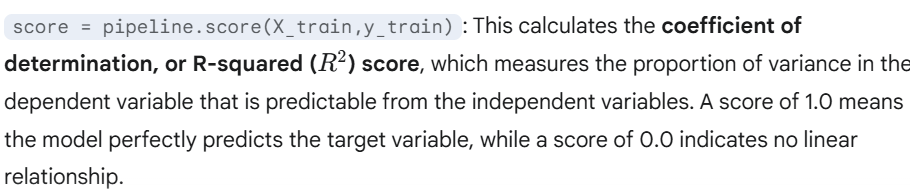

# Logistic Regression

In [ ]:

columns_to_select = ['City Name','Package','Variety', 'Origin','Item Size', 'Color']
pumpkins = full_pumpkins.loc[:, columns_to_select]

pumpkins.dropna(inplace=True)

In [ ]:
import seaborn as sns

palette = {
'ORANGE': 'orange',
'WHITE': 'wheat',
}

sns.catplot(
data=pumpkins, y="Variety", hue="Color", kind="count",
palette=palette, 
)

In [ ]:
from sklearn.preprocessing import OrdinalEncoder

item_size_categories = [['sml', 'med', 'med-lge', 'lge', 'xlge', 'jbo', 'exjbo']]
ordinal_features = ['Item Size']
ordinal_encoder = OrdinalEncoder(categories=item_size_categories)

from sklearn.preprocessing import OneHotEncoder

categorical_features = ['City Name', 'Package', 'Variety', 'Origin']
categorical_encoder = OneHotEncoder(sparse_output=False)


from sklearn.compose import ColumnTransformer

ct = ColumnTransformer(transformers=[
    ('ord', ordinal_encoder, ordinal_features),
    ('cat', categorical_encoder, categorical_features)
    ])

ct.set_output(transform='pandas')
encoded_features = ct.fit_transform(pumpkins)

from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
encoded_label = label_encoder.fit_transform(pumpkins['Color'])

encoded_pumpkins = encoded_features.assign(Color=encoded_label)

In [ ]:
from sklearn.model_selection import train_test_split

X = encoded_pumpkins[encoded_pumpkins.columns.difference(['Color'])]
y = encoded_pumpkins['Color']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)


from sklearn.metrics import f1_score, classification_report 
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(X_train, y_train)
predictions = model.predict(X_test)

print(classification_report(y_test, predictions))
print('Predicted labels: ', predictions)
print('F1-score: ', f1_score(y_test, predictions))

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, predictions)


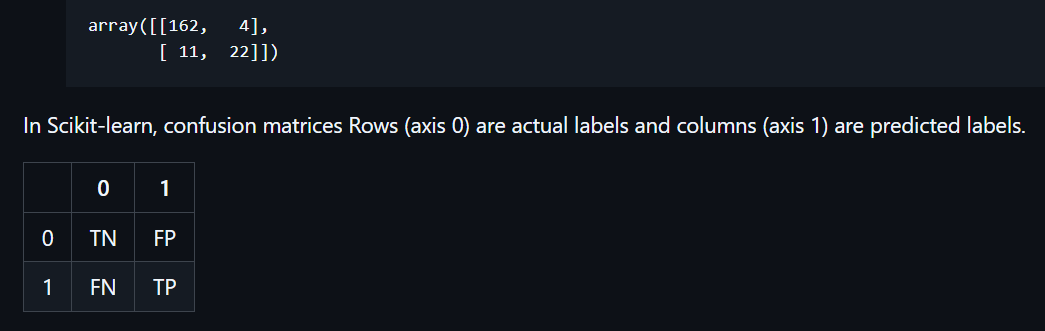

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

y_scores = model.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_scores[:,1])

fig = plt.figure(figsize=(6, 6))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

auc = roc_auc_score(y_test,y_scores[:,1])
print(auc)